In [1]:
# Import
import pandas as pd
import os
import matplotlib.pyplot as plt
import math
import numpy as np
from scipy.optimize import curve_fit
from sympy.solvers import solve
from sympy import Symbol

In [2]:
"""
    Reading the csv files of non-stoichiometry data into pandas dataframes;
        the csv files are named as "pO2=~.csv", 
        the three columns are "T", "Delta", "pO2
    The dataframes for each pO2 are put in a python dictionary, 
        and the keys are the pO2 in the name of the files
    Data in files come from TGA measurements
"""
os.listdir('.')
csv_names = [f for f in os.listdir('.') if '.csv' in f]
data_sets = {}
for csv_name in csv_names:
    df = pd.read_csv(csv_name)
    temp = csv_name.replace('pO2=', '')
    pO2 = temp.replace('.csv', '')
    # Due to the presence of delta below 0, 
    # data larger than a "arbitrary limit" are admitted for fitting
    # for STM55 data, 5e-4 is chosen, value can be changed for best fitting
    df_filtered = df[df['Delta'] >= 5e-4]
    data_sets[pO2] = df_filtered

In [3]:
"""
    deltafunct:
        The function used to fit delta as a function of T,
        Later used to find T at each delta
    arrfun:
        The function calculates the exponential of pO2 given
        enthalpy, entropy and inverse temperature
"""
def deltafunct(T, a, b, c, d):
    return a*np.power(T, 4) + b*np.power(T, 3) + c*np.power(T, 2) + d*T
def arrfun(T_inv, H, S):
    return 2*(-H/(8.314)*T_inv + S/8.314)

In [4]:
"""
    For each pO2, the non-stoichiometry curve as a function of T is defined 
        with deltafunct, curve_fit functions are used to find optimal parameters:
        a, b, c, d
    The maximum and minimum temperature, delta are also inclued as tuples
    parameter_set is a dictionary of these data with structure:
        {pO2: [a, b, c, d], (min_delta, max_delta), (min_temperature, max_temperature)}
"""
parameter_set = {}
for pO2 in data_sets:
    df = data_sets[pO2]
    temps = df['T']
    deltas = df['Delta']
    temps_list = temps.tolist()
    deltas_list = deltas.tolist()
    parameters, covariance = curve_fit(deltafunct, temps_list, deltas_list)
    d_lim = (min(deltas), max(deltas))
    T_lim = (min(temps), max(temps))
    parameter_set[pO2] = [parameters.tolist(), d_lim, T_lim]
    

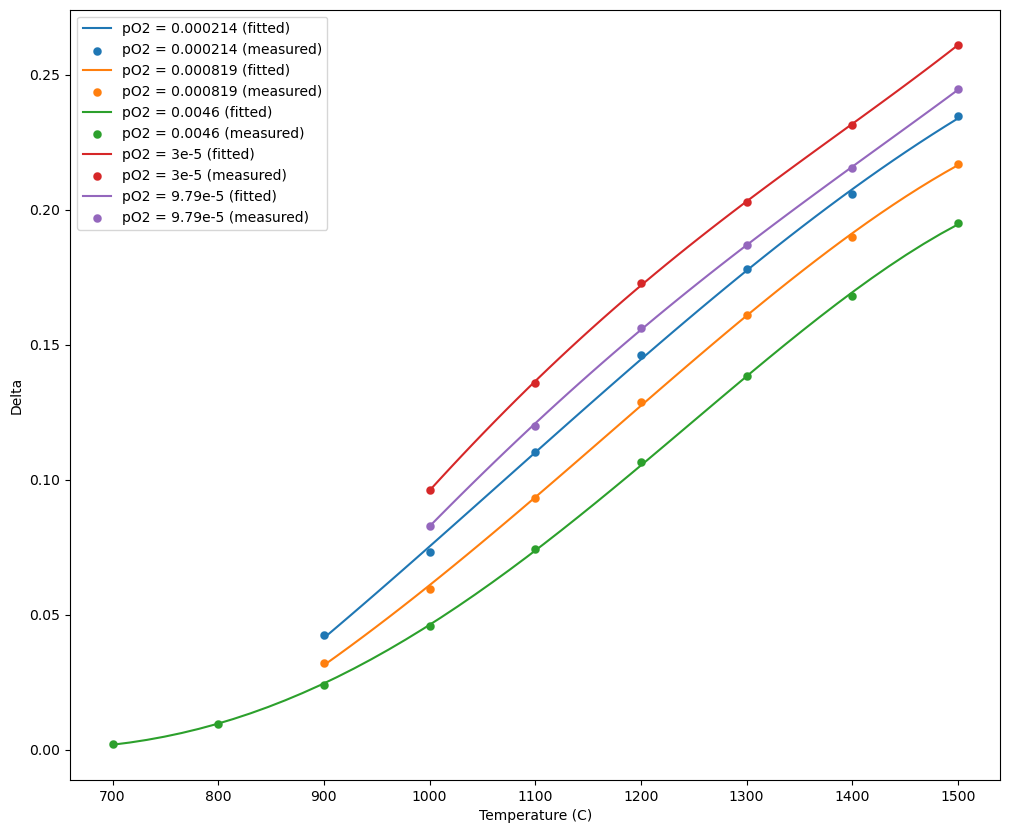

In [5]:
"""
    With the parameters obtained from previous cell, 
        for specific pO2, delta can be expressed as a function of temperature 
        within the range of temperature considered
    Only low-pO2 data are ploted in this cell, scattered dots are measured, curves are calculated from fitting
"""
plt.figure(figsize=(12,10))
legend_list = []
for pO2 in [pO2 for pO2 in parameter_set.keys() if float(pO2) < 0.005]:
    parameters = parameter_set[pO2][0]
    a = parameters[0]
    b = parameters[1]
    c = parameters[2]
    d = parameters[3]
    T_min = parameter_set[pO2][2][0]
    T_max = parameter_set[pO2][2][1]
    T_range = np.linspace(T_min, T_max)
    deltas_calc = [deltafunct(T, a, b, c, d) for T in T_range]
    plt.plot(T_range, deltas_calc)
    df = data_sets[pO2]
    temps = df['T']
    deltas = df['Delta']
    plt.scatter(temps, deltas, linewidth = 0.1)
    legend_list.append('pO2 = ' + pO2)
plt.xlabel('Temperature (C)')
plt.ylabel('Delta')
legend_final = []
for entry in legend_list:
    legend_final.append(entry + ' (fitted)')
    legend_final.append(entry + ' (measured)')
plt.legend(legend_final)
    

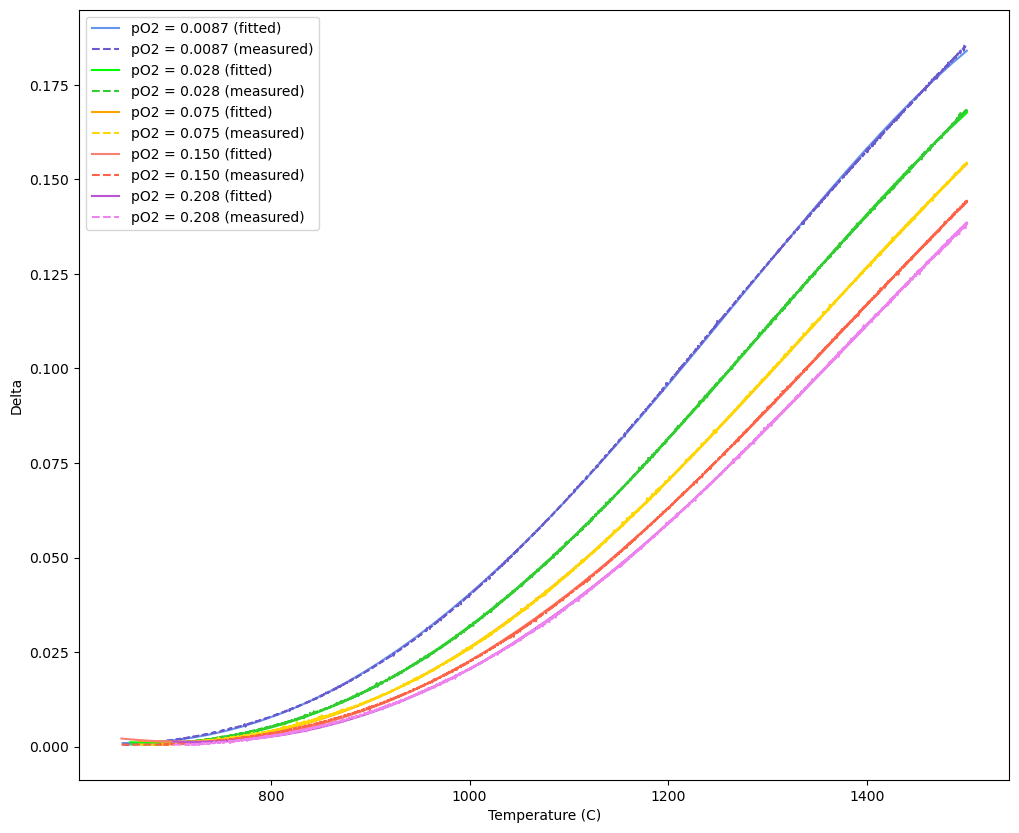

In [6]:
"""
    This cell plots the high-pO2 cases ("Continuous" data)
"""
plt.figure(figsize=(12,10))
legend_list = []
colorlist = ['cornflowerblue', 'lime', 'orange', 'salmon', 'mediumorchid']
colorlist_2 = ['slateblue', 'limegreen', 'gold', 'tomato', 'violet']
i = 0
for pO2 in [pO2 for pO2 in parameter_set.keys() if float(pO2) > 0.005]:
    parameters = parameter_set[pO2][0]
    a = parameters[0]
    b = parameters[1]
    c = parameters[2]
    d = parameters[3]
    T_min = parameter_set[pO2][2][0]
    T_max = parameter_set[pO2][2][1]
    T_range = np.linspace(T_min, T_max)
    deltas_calc = [deltafunct(T, a, b, c, d) for T in T_range]
    plt.plot(T_range, deltas_calc , color = colorlist[i])
    df = data_sets[pO2]
    temps = df['T']
    deltas = df['Delta']
    plt.plot(temps, deltas, linestyle = 'dashed', color = colorlist_2[i])
    legend_list.append('pO2 = ' + pO2 + ' (fitted)')
    legend_list.append('pO2 = ' + pO2 + ' (measured)')
    i += 1
plt.xlabel('Temperature (C)')
plt.ylabel('Delta')
plt.legend(legend_list)
    

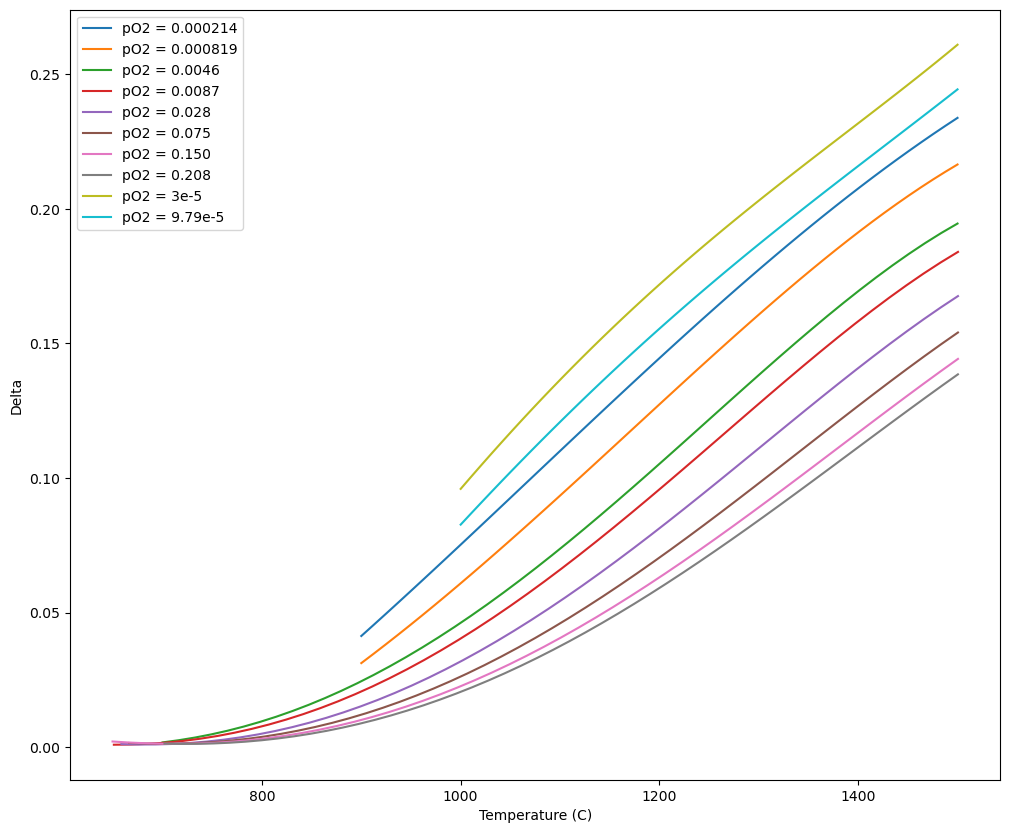

In [7]:
"""
    This cell plots all calculated data 
"""
plt.figure(figsize=(12,10))
legend_list = []
for pO2 in parameter_set.keys():
    parameters = parameter_set[pO2][0]
    a = parameters[0]
    b = parameters[1]
    c = parameters[2]
    d = parameters[3]
    T_min = parameter_set[pO2][2][0]
    T_max = parameter_set[pO2][2][1]
    T_range = np.linspace(T_min, T_max)
    deltas_calc = [deltafunct(T, a, b, c, d) for T in T_range]
    plt.plot(T_range, deltas_calc)
    df = data_sets[pO2]
    temps = df['T']
    deltas = df['Delta']
    #plt.scatter(temps, deltas)
    legend_list.append('pO2 = ' + pO2)
plt.xlabel('Temperature (C)')
plt.ylabel('Delta')
plt.legend(legend_list)
    

In [8]:
"""
    At each pO2, with known parameters a, b, c, d in function deltafunct:
        temperature can be calculated at each delta, 
        and iso-stoichiometric curve (log(pO2) as function of 1/T) can be obtained
    Iso-stoichiometric curve are fitted using funtion arrfun:
        enthalpy and entropy are found at each delta
"""
test_delta = np.linspace(0.004, 0.24, 150)
H = []
S = []
for delta in test_delta:
    result = [[], []]
    for pO2 in parameter_set.keys():
        d_limits = parameter_set[pO2][1]
        if delta >= d_limits[0] and delta <= d_limits[1]:
            result[0].append(np.log(float(pO2)))
            T_limits = parameter_set[pO2][2]
            parameters = parameter_set[pO2][0]
            a = parameters[0]
            b = parameters[1]
            c = parameters[2]
            d = parameters[3]
            x = Symbol('x')
            solutions = solve(a*x**4 + b*x**3 + c*x**2 + d*x**1 - delta, x)
            solutions = [abs(a) for a in solutions]
            solution_final = [a for a in solutions if (a >= T_limits[0] - 50 and a <= T_limits[1] + 50)][0]
            result[1].append(1/(solution_final + 273.15))
    thermos, covariance = curve_fit(arrfun, result[1], result[0]) 
    H.append(thermos[0])
    S.append(thermos[1])

C:\Users\admin\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Text(0, 0.5, 'Entropy (J/mol)')

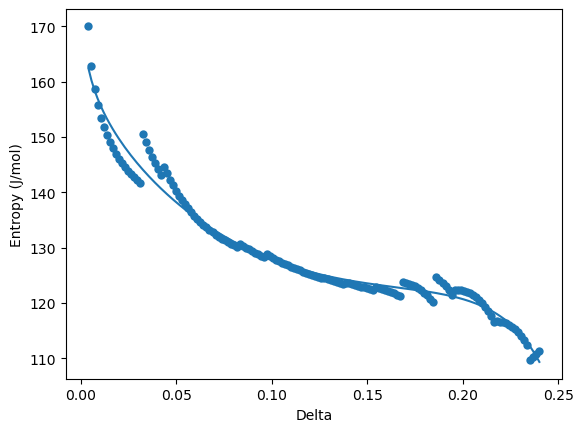

In [9]:
"""
    Plotting acquired entropy data as a function of delta, and fit with function test_S
    Test_S:
        contains both log(delta) and log(m-delta) where m is larger than highest delta value measured
"""
plt.scatter(test_delta, S, linewidth = 1e-5)
def test_S(delta, a, b, c, d, S_e):
    return a*np.log(delta) + b*np.log(0.27-delta) + c*np.square(delta) + d*delta + S_e
parameters, covariance = curve_fit(test_S, test_delta, S)
a = parameters[0]
b = parameters[1]
c = parameters[2]
d = parameters[3]
S_e = parameters[4]

calc_S = [test_S(delta, a, b, c, d, S_e) for delta in test_delta]
plt.plot(test_delta, calc_S)
plt.xlabel('Delta')
plt.ylabel('Entropy (J/mol)')


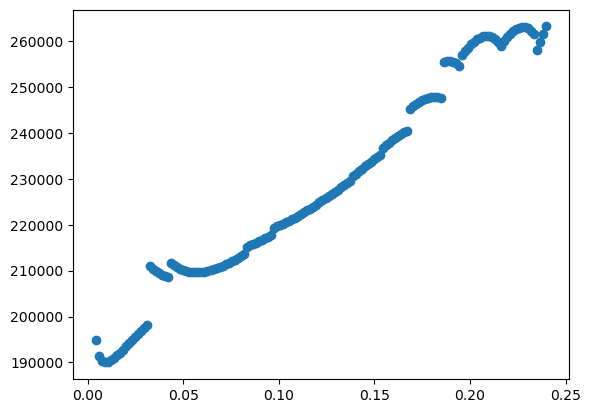

In [10]:
plt.scatter(test_delta, H)

In [11]:
"""
    Create a combined dataframe of all data for 3D fitting
"""
frames = []
for df_name in data_sets:
    df = data_sets[df_name]
    inverse_temp = [1/(T + 273.15) for T in df['T']]
    log_pO2 = [math.log(pO2) for pO2 in df['pO2']]
    df['1/T'] = inverse_temp
    df['log_pO2'] = log_pO2
    frames.append(df)
    merged = pd.concat(frames)
#merged = merged[merged['Delta'] <= 0.2499999999999999999999]

In [12]:
"""
    Using known entropy function, assuming linear dependance of enthalpy on delta,
    create a function that finds log(pO2) at given delta and temperature,
    the function is used to find fitting parameters H0 and k
"""
R = 8.314
def test_func(data, H0, k):
    
    def func_enthalpy(delta):
        return H0 + k*delta
    
    def func_entropy(delta):
        return test_S(delta, a, b, c, d, S_e)
    
    if not isinstance(data[0], int):
        temps = data[0]
        deltas = data[1] 
        if len(temps) != len(deltas):
            print('Unequal list length')
            return
        else:
            log_pO2 = []
            for i in range(len(temps)):
                T = temps[i]
                delta = deltas[i]
                enthalpy = func_enthalpy(delta)
                entropy = func_entropy(delta)
                result = 2*(-enthalpy/(R*(T + 273.15)) + entropy/R)
                log_pO2.append(result)
    else:
        T = data[0]
        delta = data[1]
        enthalpy = func_enthalpy(delta)
        entropy = func_entropy(delta)
        result = 2*(-enthalpy/(R*(T + 273.15)) + entropy/R)
    return log_pO2

In [13]:
temp_list = merged['T'].tolist()
delta_list = merged['Delta'].tolist()
log_pO2_list = merged['log_pO2'].tolist()
entry_data = [temp_list, delta_list]
#calc_S = [test_S(delta, a, b, c, d, S_e) for delta in delta_list]
#plt.scatter(delta_list, calc_S)

In [14]:
# performs a 3D fitting to find H0 and k
parameters, covariance = curve_fit(test_func, entry_data, log_pO2_list)

In [15]:
print(parameters)
H0 = parameters[0]
k = parameters[1]

[186479.0757537  344754.89515657]


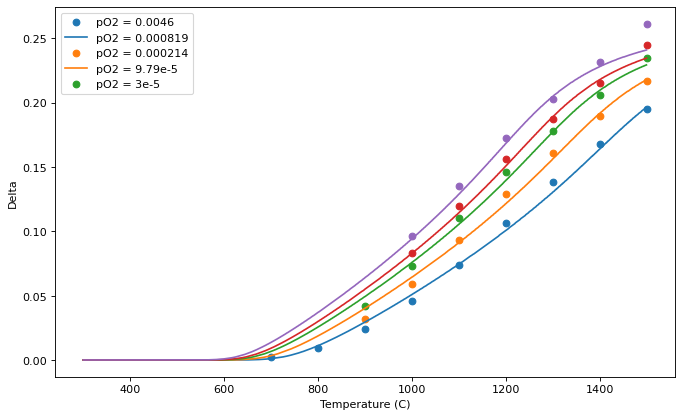

In [16]:
def test_H(d):
        return (H0 + k*d)/1000
    
def find_eq_pO2(delta, T):
    result = 2*(-test_H(delta)*1000 + T*test_S(delta, a, b, c, d, S_e)) / (R*T)
    return np.exp(result)

def find_delta(T, pO2, min_delta = 0.0001, max_delta = 0.269999999):
    min_pO2 = find_eq_pO2(max_delta, T)
    eq_pO2 = find_eq_pO2(min_delta, T)
    if pO2 >= eq_pO2:
        return min_delta
    else:
        if pO2 < min_pO2:
            print('Sample completely reduced')
            return max_delta
        else:
            test_delta = (min_delta + max_delta) / 2
            eq_pO2 = find_eq_pO2(test_delta, T)
            while abs(math.log10(eq_pO2) - math.log10(pO2)) > 0.005:
                if eq_pO2 > pO2:
                    min_delta = test_delta
                    test_delta = (min_delta + max_delta) / 2
                    eq_pO2 = find_eq_pO2(test_delta, T)
                else:
                    max_delta = test_delta
                    test_delta = (min_delta + max_delta) / 2
                    eq_pO2 = find_eq_pO2(test_delta, T)
        return test_delta
temp_vals = range(300, 1500)
plt.figure(figsize=(10, 6), dpi=80)
for pO2 in ['0.0046', '0.000819', '0.000214', '9.79e-5', '3e-5']:
    T = data_sets[pO2]['T']
    delta = data_sets[pO2]['Delta']
    plt.scatter(T, delta)
    delta_calc = [find_delta(T+273.15, float(pO2)) for T in temp_vals]
    plt.plot(temp_vals, delta_calc)
plt.xlabel('Temperature (C)')
plt.ylabel('Delta')
plt.legend(['pO2 = 0.0046', 'pO2 = 0.000819', 'pO2 = 0.000214', 'pO2 = 9.79e-5', 'pO2 = 3e-5'])

In [17]:
R = 8.314
def test_func(data, a, b, c, d, S_e):
    
    def func_enthalpy(d):
        return test_H(d)*1000
    
    def func_entropy(delta):
        return a*np.log(delta) + b*np.log(0.27-delta) + c*np.square(delta) + d*delta + S_e

    
    if not isinstance(data[0], int):
        temps = data[0]
        deltas = data[1] 
        if len(temps) != len(deltas):
            print('Unequal list length')
            return
        else:
            log_pO2 = []
            for i in range(len(temps)):
                T = temps[i]
                delta = deltas[i]
                enthalpy = func_enthalpy(delta)
                entropy = func_entropy(delta)
                result = 2*(-enthalpy/(R*(T + 273.15)) + entropy/R)
                log_pO2.append(result)
    else:
        T = data[0]
        delta = data[1]
        enthalpy = func_enthalpy(delta)
        entropy = func_entropy(delta)
        result = 2*(-enthalpy/(R*(T + 273.15)) + entropy/R)
    return log_pO2

In [18]:
entry_data = [temp_list, delta_list]
new_parameters, covariance = curve_fit(test_func, entry_data, log_pO2_list)

In [19]:
new_parameters

array([-10.42611899,  33.75950603, 702.49438772,  70.477483  ,
       150.44658876])

Text(0, 0.5, 'Entropy (J/mol)')

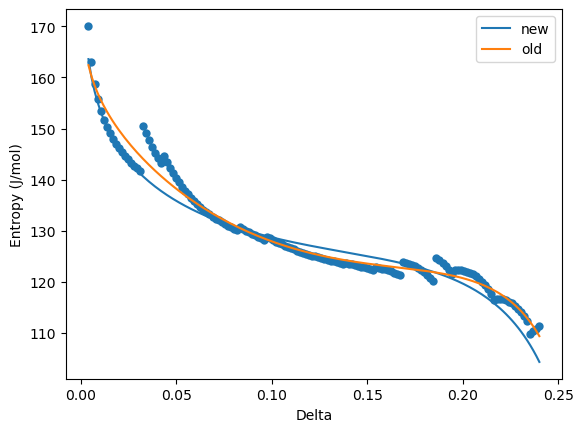

In [23]:
new_a = new_parameters[0]
new_b = new_parameters[1]
new_c = new_parameters[2]
new_d = new_parameters[3]
new_S_e = new_parameters[4]
def new_S(delta):
    return new_a*np.log(delta) + new_b*np.log(0.27-delta) + new_c*np.square(delta) + new_d*delta + new_S_e
new_calc_S = [new_S(delta) for delta in test_delta]
plt.plot(test_delta, new_calc_S)
plt.plot(test_delta, calc_S)
plt.scatter(test_delta, S, linewidth = 1e-5)
plt.legend(['new', 'old'])
plt.xlabel('Delta')
plt.ylabel('Entropy (J/mol)')

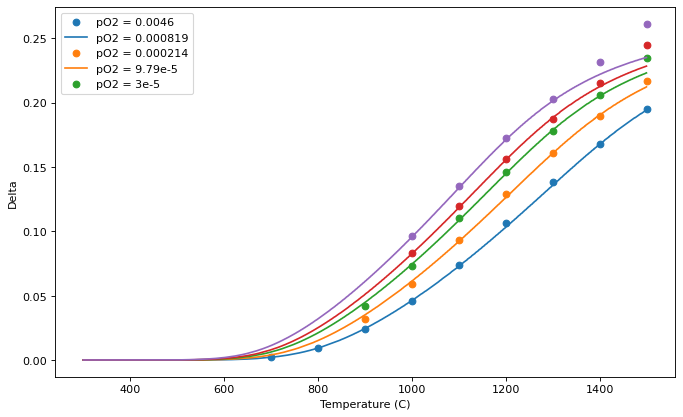

In [22]:
def test_H(d):
        return (H0 + k*d)/1000

def find_eq_pO2(delta, T):
    result = 2*(-test_H(delta)*1000 + T*new_S(delta)) / (R*T)
    return np.exp(result)

def find_delta(T, pO2, min_delta = 0.0001, max_delta = 0.269999999):
    min_pO2 = find_eq_pO2(max_delta, T)
    eq_pO2 = find_eq_pO2(min_delta, T)
    if pO2 >= eq_pO2:
        return min_delta
    else:
        if pO2 < min_pO2:
            print('Sample completely reduced')
            return max_delta
        else:
            test_delta = (min_delta + max_delta) / 2
            eq_pO2 = find_eq_pO2(test_delta, T)
            while abs(math.log10(eq_pO2) - math.log10(pO2)) > 0.005:
                if eq_pO2 > pO2:
                    min_delta = test_delta
                    test_delta = (min_delta + max_delta) / 2
                    eq_pO2 = find_eq_pO2(test_delta, T)
                else:
                    max_delta = test_delta
                    test_delta = (min_delta + max_delta) / 2
                    eq_pO2 = find_eq_pO2(test_delta, T)
        return test_delta
temp_vals = range(300, 1500)
plt.figure(figsize=(10, 6), dpi=80)
for pO2 in ['0.0046', '0.000819', '0.000214', '9.79e-5', '3e-5']:
    T = data_sets[pO2]['T']
    delta = data_sets[pO2]['Delta']
    plt.scatter(T, delta)
    delta_calc = [find_delta(T+273.15, float(pO2)) for T in temp_vals]
    plt.plot(temp_vals, delta_calc)
plt.xlabel('Temperature (C)')
plt.ylabel('Delta')
plt.legend(['pO2 = 0.0046', 'pO2 = 0.000819', 'pO2 = 0.000214', 'pO2 = 9.79e-5', 'pO2 = 3e-5'])